# Fandango Seating Analysis

Create a heat-map of a theater seating-chart indicating the average demand of a seat given its position relative to the screen. Do this using a sort of Gaussian kernel density estimation where the value of a position in a theater corresponds to the average fraction of open seats in the theater when a seat at that position is reserved.

**Seating Convention Notes:**

* Every seat is labeled with a letter (indicating row) and a 1-indexed number (indicating column).
* Row letters increase from the **front** to the **back** of the theater (from closest to farthest from the screen).
* Column numbers increase from **house right** to **house left** (i.e., right to left when the screen is in front of you).
* Not every row is guaranteed to have the same number of columns.
* Sometimes, a row may have missing column numbers due to walkways, handicap spaces, or unusual seating arrangements.

**Visualization Notes:**

* If a column number is missing for a given row in a seating chart, I will assume that the lack of this column number accounts for a physical gap in the seating chart. Thus, I will take the number of columns in a row to be equal to the highest column number in that row specified by the seating chart. All resulting gaps will be treated as seats with 0 demand.
* Since theaters come in many shapes and sizes, I will map all seating charts onto a standardized square grid. This mapping process is 2 steps:
  1. Map the seats onto a rectangular space such that if a theater has N rows and M columns, the rectangle can be populated with N * M square-packed circles of equal radius (where each circle represents 1 seat located approximately at the circle's center).
    * We can account for leg-room by multiplying the vertical distance by some constant leg-room factor.
  2. Then stretch the rectangle (and the circles that fill it) vertically or horizontally so that the seats fill the space of a square.
* I will assume that every seat in a theater is the same size.
* I will assume that each row is centered along the axis which divides the theater into a left and right half. Thus, if a row has fewer columns than the highest possible number of columns in that theater, the permanently unoccupied space at the left and right edges of that row will be be treated as seats with 0 demand.
* Choosing a colormap: https://matplotlib.org/users/colormaps.html

In [126]:
import os
import json
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

### Load data from file

In [81]:
def get_file_path(movie_params):
    
    data_dir = movie_params["data_dir"]
    movies_dir = movie_params["movies_dir"]
    movie_dir = movie_params["movie_dir"]
    theater_dir = movie_params["theater_dir"]
    file_name = movie_params["file_name"]
    
    file_path = "../" + "/".join([data_dir, movies_dir, movie_dir, theater_dir, file_name])
    
    return file_path
    
def load_data(file_path):
    
    with open(file_path, "r") as fp:
        data = fp.readlines()

    data = [json.loads(x.strip().replace("'", '"')) for x in data]
    config = data[0]
    snapshots = data[1:]
    
    return config, snapshots

### Process seat configuration data

In [82]:
def process_seat_config_data(config):

    seat_labels = config["seats"]
    seat_let_num = [[x[0], int(x[1:])] for x in seat_labels]
    letters = sorted(list(set([x[0] for x in seat_let_num])))
    letter_to_row = dict(zip(letters, [i + 1 for i in range(len(letters))]))

    seat_row_col = [[letter_to_row[x[0]], x[1]] for x in seat_let_num]

    num_seats = len(seat_row_col)
    num_rows = len(letters)
    num_cols = [max([x[1] for x in seat_row_col if x[0] == i + 1]) for i in range(num_rows)]
    
    seat_config_data = {
        "num_seats": num_seats,
        "num_rows": num_rows,
        "num_cols": num_cols
    }
    
    return seat_config_data

### Process seat snapshot data

In [83]:
def process_snapshots(snapshots, seat_config_data):

    num_seats = seat_config_data["num_seats"]
    
    reserved = [snap[1]["R"] for snap in snapshots]

    seat_sets = []
    seat_set = set()

    for r in reserved:

        new_seat_set = set(r)

        added_seats = new_seat_set - seat_set

        if added_seats:
            seat_set = seat_set.union(added_seats)
            frac_remaining = 1 - (len(seat_set) / num_seats)
            seat_sets.append([frac_remaining, added_seats])
    
    seat_reservations = np.array([[*seat_row_col[s], x[0]] for x in seat_sets for s in x[1]])
    
    return seat_reservations

def seat_row_col_to_rect_xy(seats, seat_config_data, plotting_params):
    
    # seats = np.array([row, col, demand]), with 1-indexed row and col values
    
    num_rows = seat_config_data["num_rows"]
    num_cols = np.array(seat_config_data["num_cols"])
    leg_room = plotting_params["leg_room"]
    
    row = seats[:, 0]
    col = seats[:, 1]
    
    x = -(col - 1) + (num_cols[row.astype("int") - 1] - 1)/2
    y = (-(row - 1) + (num_rows - 1)/2) * leg_room
    
    pos = np.empty_like(seats)
    pos[:] = seats
    pos[:, 0] = x
    pos[:, 1] = y
    
    return pos

### Compute rectangular heat-map

In [84]:
def compute_rect_heat_map(seat_positions, seat_config_data, plotting_params):

    num_rows = seat_config_data["num_rows"]
    num_cols = seat_config_data["num_cols"]
    blip_width = plotting_params["blip_width"]
    leg_room = plotting_params["leg_room"]
    resolution = plotting_params["resolution"]
    p = plotting_params["p"]
    
    seat_x_max = max(num_cols)/2
    seat_y_max = (num_rows/2) * leg_room

    x_min = -(seat_x_max + leg_room)
    x_max = -x_min
    y_min = -(seat_y_max + leg_room) 
    y_max = seat_y_max + 2 * leg_room

    x = np.linspace(x_min, x_max, resolution)
    y = np.linspace(y_min, y_max, resolution)
    s = np.repeat(1, len(seat_positions))

    X, Y, _ = np.meshgrid(x, y, s)

    X_0 = seat_positions[:, 0]
    Y_0 = seat_positions[:, 1]
    d = seat_positions[:, 2]

    D_individual = (d ** p) * np.exp(-((X - X_0)**2 + (Y - Y_0)**2) / blip_width ** 2)
    D = np.sum(D_individual, axis = 2)
    
    heat_map_data = {
        "X": X,
        "Y": Y,
        "D": D
    }
    
    return heat_map_data

### Plot rectangular heat-map

In [162]:
def plot_rect_heat_map(heat_map_data,
                       plotting_params,
                       plot_seating_chart=True,
                       movie_data_fp=None,
                       config=None,
                       save_fig=False,
                       display_fig=True):

    seat_color = "black"
    screen_color = "gray"
    alpha = 0.4
    
    fig = plt.figure(figsize = (15, 15))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlim(-x_max, x_max)
    ax.set_ylim(-y_max, y_max)
    ax.axis("equal")
    ax.axis("off")
    
    title = "Movie Theater Heat-Map"
    
    if movie_data_fp:
        
        path_dirs = movie_data_fp.split(".")[-2].split("/")

        movie_title = path_dirs[-3]
        movie_venue = path_dirs[-2]
        movie_time = "_".join(path_dirs[-1].split("_")[:2])
        auditorium = config["auditorium"]
        
        parsed_time = datetime.strptime(movie_time, "%Y-%m-%d_%H%M")
        formatted_time = datetime.strftime(parsed_time, "%Y/%m/%d - %I:%M %p (%A)")
        
        font = {'family': 'Century Gothic', 'weight': 'normal', 'size' : 14}
        plt.rc('font', **font)
        
        ax.set_title("%s\n%s\n%s | %s" % (movie_title, movie_venue[8:], auditorium, formatted_time),
                     fontdict = {'fontsize': 16, 'weight': 'bold'},
                     y = 0.93)
    
    X = heat_map_data["X"]
    Y = heat_map_data["Y"]
    D = heat_map_data["D"]
    N = plotting_params["N"]
    p = plotting_params["p"]
    
    # Plot heat-map
    ax.contourf(X[:, :, 0], Y[:, :, 0], D, N, 
                cmap = "RdYlBu_r", vmin = 0, vmax = 1.1**p)
    
    # Plot movie screen
    screen_xy_anchor = (x_min + leg_room/2, y_max - leg_room)
    screen_width = 2 * x_max - leg_room
    screen_height = 1.25
    ax.add_patch(patches.Rectangle(screen_xy_anchor, 
                                   width = screen_width,
                                   height = screen_height,
                                   fc = screen_color))
    # Plot seating chart
    if plot_seating_chart:
        
        seat_width = plotting_params["seat_width"]
        seat_patches_xy = seat_config_pos - np.array([seat_width, seat_width])/2
        
        
        for p in seat_patches_xy:
            
            ax.add_patch(patches.Rectangle(tuple(p), 
                                           width=seat_width, 
                                           height=seat_width, 
                                           ec=seat_color, 
                                           alpha=alpha, 
                                           fill=None))
            
    # Save heat-map plot to file, grouped by auditorium
    if save_fig and movie_data_fp and config:
        
        image_dir = "../images/%s/%s" % (movie_venue, auditorium)
        image_name = "%s_%s.png" % (movie_title, movie_time)
        
        if not os.path.exists(image_dir):
            os.makedirs(image_dir)

        plt.savefig("/".join([image_dir, image_name]), 
                    dpi = 600, 
                    bbox_inches = "tight",
                    pad_inches = 0,
                    transparent = True)

    # Display heat-map
    if display_fig:
        plt.show()
        plt.gcf().clear()
    
    return

### Run pipeline: movie data file to heat-map

In [91]:
def create_heat_map_from_movie_data(file_path, 
                                    plotting_params,
                                    plot_seating_chart=True,
                                    save_fig=False,
                                    display_fig=True):
    
    # Load data from file
    config, snapshots = load_data(file_path)

    # Process seat configuration data
    seat_config_data = process_seat_config_data(config)

    # Process seat snapshot data
    seat_reservations = process_snapshots(snapshots, seat_config_data)
    seat_positions = seat_row_col_to_rect_xy(seat_reservations, seat_config_data, plotting_params)
    seat_config_pos = seat_row_col_to_rect_xy(np.array(seat_row_col), seat_config_data, plotting_params)

    # Compute rectangular heat-map
    heat_map_data = compute_rect_heat_map(seat_positions, seat_config_data, plotting_params)

    # Plot rectangular heat-map
    plot_rect_heat_map(heat_map_data, 
                       plotting_params,
                       plot_seating_chart = plot_seating_chart,
                       movie_data_fp = file_path,
                       config = config,
                       save_fig = save_fig,
                       display_fig = display_fig)
        
    return

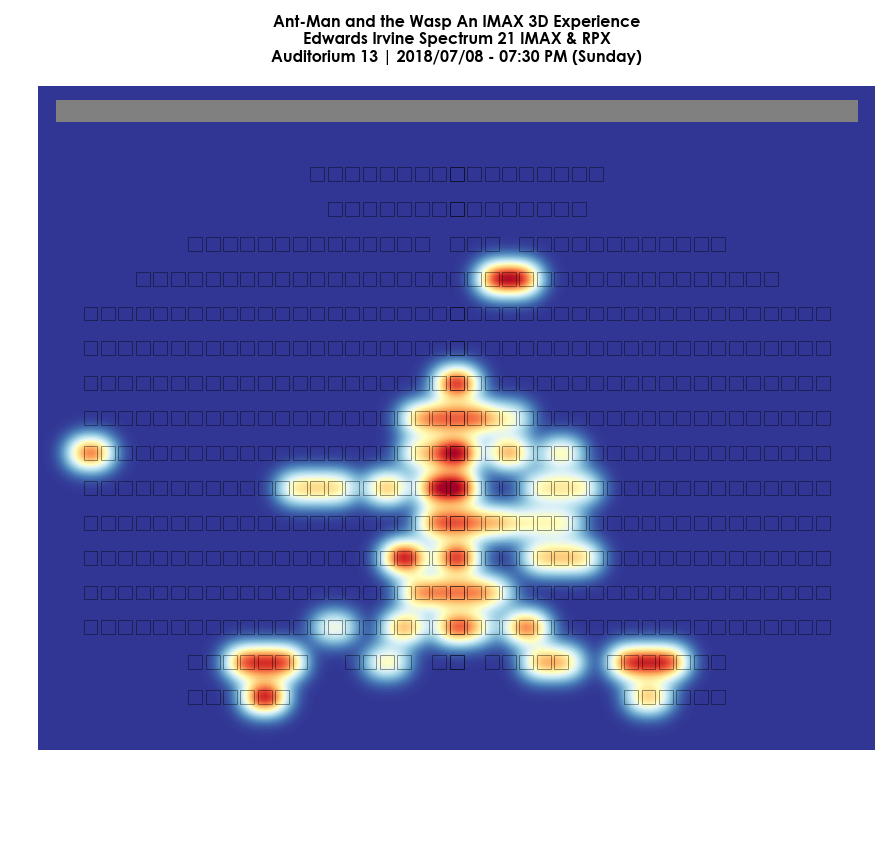

In [163]:
plotting_params = {
    
    "blip_width": 1,       # size of Gaussian blip relative to x-distance between adjacent seat centers
    "seat_width": 0.8,     # size of seat bounding box relative to x-distance between adjacent seat centers
    "leg_room": 2,         # ratio of y-dist./x-dist. between two vert./horiz. adjacent seat centers
    "resolution": 200,     # number of points to be computed across one dimension of the heat-map domain
    "p": 5,                # power (exponent) for non-linearly weighting seat demand values
    "N": 1000              # number of contour levels to be plotted
    
}

# movie_dir = "Ant-Man and the Wasp"
# theater_dir = "AABTB - Edwards Irvine Spectrum 21 IMAX & RPX"
# file_name = "2018-07-07_2030_152615700.txt"

# movie_dir = "Ant-Man and the Wasp"
# theater_dir = "AABFB - Edwards Big Newport 6 & RPX"
# file_name = "2018-07-07_2115_156826611.txt"


movie_params = {
    
    "data_dir": "data",
    "movies_dir": "movies",
    "movie_dir": "Ant-Man and the Wasp An IMAX 3D Experience",
    "theater_dir": "AABTB - Edwards Irvine Spectrum 21 IMAX & RPX",
    "file_name": "2018-07-08_1930_154574587.txt"

}

file_path = get_file_path(movie_params)

create_heat_map_from_movie_data(file_path, plotting_params)